# The Deep DRT: a neural network approach to deconvolve the Distribution of relaxation times

In this tutorial we will show use the deep-DRT method to analyze actual experimental data. Specifically we will fit EIS data from a symmetric cell built with a material for a solid oxide fuel cell.

The impedance data is collected in the folder "data folder" and the EIS data is saved in csv format. Each file has three columns. The first column is the frequency, the second one the real part of the impedance. The third column is the imaginary part of impedance.

### Load necessary modules

In [9]:
import os
import pandas as pd
import numpy as np
import compute_DRT
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
from math import pi

## 1) Define experimental conditions

In [11]:
# todo
L_ref = 1E-5

Tensor = torch.FloatTensor

# seed for reproducibility
torch.manual_seed(213912)

pO2_min = 20
pO2_max = 100
delta_P = 20
P_range = np.arange(pO2_min, pO2_max+delta_P, delta_P)
P_range[0]=21 # pmin = 21 in data

if pO2_min == pO2_max:
    P_range_norm = np.array([0.0])
else:
    P_range_norm = (P_range-pO2_min)/(pO2_max-pO2_min)

N_pressures = len(P_range)

T_min = 500
T_max = 700
delta_T = 50
T_range = np.arange(T_min, T_max+delta_T, delta_T)
if T_min == T_max:
    T_range_norm = np.array([0.0])
else:
    T_range_norm = (T_range-T_min)/(T_max-T_min)

N_temps = len(T_range)

### 1.1) Define frequency range

In [12]:
N_taus = 10*10+1
tau_vec = np.logspace(-7, 3, num = N_taus, endpoint=True).reshape(N_taus,1)
log_tau_vec = np.log(tau_vec)
log_tau_vec_norm = -1.+2.*(log_tau_vec-log_tau_vec.min())/(log_tau_vec.max()-log_tau_vec.min())

### 1.2) Define necessary list and build discretization matrices

In [14]:
# declare lists that store:
# 1) data
freq_times_Lref_list = []
Z_re_list = []
Z_im_list = []
# 2) DRT-to-impedance and derivative matrices
A_re_list = []
A_im_list = []
L_list = []
# 3) indices for unpacking
index_unpack_list = []

# this is for the NN input
input_RL_NN = np.array([], dtype=np.int64).reshape(0,2) # only T e P for now
input_gamma_NN = np.array([], dtype=np.int64).reshape(0,3) # no zeta for now

for index1, pressure in enumerate(P_range):
    for index2, temp in enumerate(T_range):
            
        # df = pd.read_csv(os.path.dirname(__file__)+'\\data_folder\\BLF_D5_pO2_'+str(pressure)+'%_T'+str(temp)+'.csv')
        # df = pd.read_csv('./experimental_data/BLF_D5_pO2_'+str(pressure)+'%_T'+str(temp)+'.csv')
        df = pd.read_csv('./experimental_data/BLF_D5_pO2_'+str(pressure)+'%_T'+str(temp)+'.csv')
        
        N_freqs = df.shape[0]
    
        # 1) data:
        # 1.a) to numpy
        freq_vec = df['freq/Hz'].to_numpy().reshape(N_freqs,1)
        Z_re = df['Re(Z)/Ohm*cm^2'].to_numpy().reshape(N_freqs,1)
        Z_im = -df['-Im(Z)/Ohm*cm^2'].to_numpy().reshape(N_freqs,1)
        # 1.b) to torch
        freq_times_Lref_torch = torch.from_numpy(freq_vec*L_ref).type(Tensor)
        Z_re_torch = torch.from_numpy(Z_re).type(Tensor)
        Z_im_torch = torch.from_numpy(Z_im).type(Tensor)
        # 1.c) in list storage
        freq_times_Lref_list.append(freq_times_Lref_torch.detach())
        Z_re_list.append(Z_re_torch.detach())
        Z_im_list.append(Z_im_torch.detach())
    
        # 2.a) build the matrices
        # 2.a.1) decide the discretization
        rbf_type = 'gaussian'
        # rbf_type = 'C0_matern'
        # rbf_type = 'pwl'
        # epsilon = 0.0 # case pwl
        epsilon = compute_DRT.compute_epsilon(tau_vec, rbf_type) # not be used if pwl
        # epsilon = 5.0
        # 2.a.2) compute them
        A_re = compute_DRT.A_re(freq_vec, tau_vec, epsilon, rbf_type)
        A_im = compute_DRT.A_im(freq_vec, tau_vec, epsilon, rbf_type)
        L = compute_DRT.L(tau_vec)
        # 2.b) port them to torch
        A_re_torch = torch.from_numpy(A_re).type(Tensor)
        A_im_torch = torch.from_numpy(A_im).type(Tensor)
        L_torch = torch.from_numpy(L).type(Tensor)
        # 2.c) in list storage
        A_re_list.append(A_re_torch.detach())
        A_im_list.append(A_im_torch.detach())
        L_list.append(L_torch.detach())
    
        # 3) set up the neural network inputs
        # 3.a) needed temperature
        # 3.b) input for the network that outputs RL
        temp_pressure_loc = (P_range_norm[index1],T_range_norm[index2])
        input_RL_NN = np.vstack((input_RL_NN, temp_pressure_loc))
        
        # 3.c) input for the gamma network
        temp_pressure_vec_loc = temp_pressure_loc*np.ones_like(log_tau_vec_norm)
        input_loc = np.hstack((temp_pressure_vec_loc, log_tau_vec_norm))
        input_gamma_NN = np.vstack((input_gamma_NN, input_loc))
        
        # 4) store indices for unpacking
        index_unpack_end = input_gamma_NN.shape[0]
        index_unpack_start = index_unpack_end-N_taus    
        index_unpack_list.append((index_unpack_start, index_unpack_end))

    
# data used in NN
input_RL_NN_torch = torch.from_numpy(input_RL_NN).type(Tensor)
input_gamma_NN_torch = torch.from_numpy(input_gamma_NN).type(Tensor)

## 2.1) The DNN system

### 2.1) Define the DNN parameters

In [5]:
# define the neural network
# D_in is input dimension;
# H is hidden dimension
# D_out is output dimension.
N_zeta = 0
D_in_gamma = 3 + N_zeta # this is the frequency + temperature + pressure + dimension of zeta
D_in_RL = 2 # this is the temperature only and Pressure
H_gamma = 50
H_RL = 10
D_out_gamma = 1
D_out_RL = 2

# Define model
class gamma_NN(torch.nn.Module):
    def __init__(self):
        
        super(gamma_NN, self).__init__()
        self.fct_1 = torch.nn.Linear(D_in_gamma, H_gamma)
        self.fct_2 = torch.nn.Linear(H_gamma, H_gamma)
        self.fct_3 = torch.nn.Linear(H_gamma, H_gamma)
        self.fct_4 = torch.nn.Linear(H_gamma, H_gamma)
        self.fct_5 = torch.nn.Linear(H_gamma, H_gamma)
        self.fct_6 = torch.nn.Linear(H_gamma, H_gamma)
        self.fct_7 = torch.nn.Linear(H_gamma, H_gamma)
        self.fct_8 = torch.nn.Linear(H_gamma, D_out_gamma)

        torch.nn.init.xavier_normal_(self.fct_1.weight)
        torch.nn.init.xavier_normal_(self.fct_2.weight)
        torch.nn.init.xavier_normal_(self.fct_3.weight)
        torch.nn.init.xavier_normal_(self.fct_4.weight)
        torch.nn.init.xavier_normal_(self.fct_5.weight)
        torch.nn.init.xavier_normal_(self.fct_6.weight)
        torch.nn.init.xavier_normal_(self.fct_7.weight)
        torch.nn.init.xavier_normal_(self.fct_8.weight)

        torch.nn.init.zeros_(self.fct_1.bias)
        torch.nn.init.zeros_(self.fct_2.bias)
        torch.nn.init.zeros_(self.fct_3.bias)
        torch.nn.init.zeros_(self.fct_4.bias)
        torch.nn.init.zeros_(self.fct_5.bias)
        torch.nn.init.zeros_(self.fct_6.bias)
        torch.nn.init.zeros_(self.fct_7.bias)
        torch.nn.init.zeros_(self.fct_8.bias)

    def forward(self, freq):

        h = F.elu(self.fct_1(freq))
        h = F.elu(self.fct_2(h))
        h = F.elu(self.fct_3(h))
        h = F.elu(self.fct_4(h))
        h = F.elu(self.fct_5(h))
        h = F.elu(self.fct_6(h))
        h = F.elu(self.fct_7(h))
        gamma = F.softplus(self.fct_8(h))        
        
        return gamma
    
# Define model
class RL_NN(torch.nn.Module):
    def __init__(self):
        
        super(RL_NN, self).__init__()
        self.fct_1 = torch.nn.Linear(D_in_RL, H_RL)
        self.fct_2 = torch.nn.Linear(H_RL, H_RL)
        self.fct_3 = torch.nn.Linear(H_RL, H_RL)
        self.fct_4 = torch.nn.Linear(H_RL, H_RL)
        self.fct_5 = torch.nn.Linear(H_RL, H_RL)
        self.fct_6 = torch.nn.Linear(H_RL, H_RL)
        self.fct_7 = torch.nn.Linear(H_RL, H_RL)
        self.fct_8 = torch.nn.Linear(H_RL, D_out_RL)

        torch.nn.init.xavier_normal_(self.fct_1.weight)
        torch.nn.init.xavier_normal_(self.fct_2.weight)
        torch.nn.init.xavier_normal_(self.fct_3.weight)
        torch.nn.init.xavier_normal_(self.fct_4.weight)
        torch.nn.init.xavier_normal_(self.fct_5.weight)
        torch.nn.init.xavier_normal_(self.fct_6.weight)
        torch.nn.init.xavier_normal_(self.fct_7.weight)
        torch.nn.init.xavier_normal_(self.fct_8.weight)

        torch.nn.init.zeros_(self.fct_1.bias)
        torch.nn.init.zeros_(self.fct_2.bias)
        torch.nn.init.zeros_(self.fct_3.bias)
        torch.nn.init.zeros_(self.fct_4.bias)
        torch.nn.init.zeros_(self.fct_5.bias)
        torch.nn.init.zeros_(self.fct_6.bias)
        torch.nn.init.zeros_(self.fct_7.bias)
        torch.nn.init.zeros_(self.fct_8.bias)

    def forward(self, freq):

        h = F.elu(self.fct_1(freq))
        h = F.elu(self.fct_2(h))
        h = F.elu(self.fct_3(h))
        h = F.elu(self.fct_4(h))
        h = F.elu(self.fct_5(h))
        h = F.elu(self.fct_6(h))
        h = F.elu(self.fct_7(h))
        gamma = F.softplus(self.fct_8(h))        
        
        return gamma


model_gamma = gamma_NN()
model_RL = RL_NN()

### 2.2) Loss function $\mathcal{L}(\boldsymbol{\theta}_{\rm RL},\boldsymbol{\theta}_{\gamma})$ used to train the DNN system 

In [6]:
def loss_fn(RL_NN_output, gamma_NN_output, freq_times_Lref_list, Z_re_list, Z_im_list, A_re_list, A_im_list, index_unpack_list):
    
    MSE = 0
    for index in range(0, len(freq_times_Lref_list)):
        
        # unpack the neural network input
        R_inf = RL_NN_output[index, 0]
        L_0 = RL_NN_output[index, 1]
        
        # unpack gamma
        index_unpack = range(index_unpack_list[index][0], index_unpack_list[index][1])
        gamma = gamma_NN_output[index_unpack,0].reshape(N_taus,1)
        
        # external data
        freq_times_Lref = freq_times_Lref_list[index]
        Z_re = Z_re_list[index]
        Z_im = Z_im_list[index]
        
        # A matrices
        A_re = A_re_list[index]
        A_im = A_im_list[index]
        
        MSE_re = torch.sum((R_inf + torch.matmul(A_re,gamma) - Z_re)**2)
        MSE_im = torch.sum((2.*pi*freq_times_Lref*L_0 + torch.matmul(A_im, gamma) - Z_im)**2)
        MSE = MSE + MSE_re + MSE_im
    
    return MSE

## 3) Training the DNN system to deconvolve DRT from EIS data

#### To train the parameters of the DNNs (i.e. weights and biases), we set the learning rate and used ADAM as optimizer to minimize the loss function $\mathcal{L}(\boldsymbol{\theta}_{\rm RL},\boldsymbol{\theta}_{\gamma})$.

In [10]:
loss_vec = np.array([])

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which tensors it should update.

learning_rate = 1e-5

optimizer = torch.optim.Adam(model_gamma.parameters(), lr=learning_rate)#, weight_decay=1E-4)
optimizer.add_param_group({"params": model_RL.parameters()})

max_iters = 100001

gamma_NN_store = torch.zeros((max_iters, N_taus, N_pressures, N_temps)).type(Tensor)
R_inf_NN_store = torch.zeros((max_iters, N_temps*N_pressures)).type(Tensor)
L_0_NN_store = torch.zeros((max_iters, N_temps*N_pressures)).type(Tensor)

# only early stop and optimum (too much time and space!)
gamma_true_NN_store = torch.zeros((2, N_taus, N_pressures, N_temps)).type(Tensor)

loss_old = 0

gamma = model_gamma(input_gamma_NN_torch)

for t in range(max_iters):
    # Forward pass: compute predicted y by passing x to the model.
    gamma_NN_output = model_gamma(input_gamma_NN_torch)
    RL_NN_output = model_RL(input_RL_NN_torch)
    
    # Compute the loss
    loss = loss_fn(RL_NN_output, gamma_NN_output, 
                    freq_times_Lref_list, Z_re_list, Z_im_list,
                    A_re_list, A_im_list, index_unpack_list)
    
    loss_new = loss.item()
    loss_old = loss_new
    
    # save it
    loss_vec = np.append(loss_vec, loss.item())
    
    # store gamma
    gamma_NN = gamma.detach()
    # gamma_NN_store[t, :] = gamma_NN_output.detach().reshape(N_temps, N_taus).T
    gamma_NN_store[t, :] = gamma_NN_output.detach().reshape(N_pressures, N_temps, N_taus).transpose( 0 , 2).transpose( 1 , 2)
    # store R_inf
    R_inf_NN_store[t,:] = RL_NN_output[:,0].detach()

    # store L_0
    L_0_NN_store[t, :] = RL_NN_output[:,1].detach()

    # and print it
    if not t%1000:
        print('iter=%d; loss=%e' % (t, loss.item()))

    # Before starting the optimizer we can note that the learning rate
    # can be modified on the go, see
    # https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
    # It would be nice to implement this option in the future.
    
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

iter=0; loss=4.877819e+05
iter=1000; loss=1.363313e+04
iter=2000; loss=4.226738e+03
iter=3000; loss=2.462266e+03
iter=4000; loss=1.368727e+03
iter=5000; loss=7.644376e+02
iter=6000; loss=5.505140e+02
iter=7000; loss=4.773410e+02
iter=8000; loss=4.354789e+02
iter=9000; loss=4.025349e+02
iter=10000; loss=3.700266e+02
iter=11000; loss=3.383966e+02
iter=12000; loss=3.090995e+02
iter=13000; loss=2.789732e+02
iter=14000; loss=2.496021e+02
iter=15000; loss=2.223468e+02
iter=16000; loss=1.730050e+02
iter=17000; loss=7.197804e+01
iter=18000; loss=1.941804e+01
iter=19000; loss=7.805728e+00
iter=20000; loss=4.573941e+00
iter=21000; loss=2.926511e+00
iter=22000; loss=2.041263e+00
iter=23000; loss=1.586814e+00
iter=24000; loss=1.354822e+00
iter=25000; loss=1.197717e+00
iter=26000; loss=1.077324e+00
iter=27000; loss=9.781582e-01
iter=28000; loss=8.874303e-01
iter=29000; loss=8.182150e-01
iter=30000; loss=7.640668e-01
iter=31000; loss=7.184118e-01
iter=32000; loss=6.782842e-01
iter=33000; loss=6.4232

## 4) comparison of the recovered DRTs with the ECMs  

In [22]:
freq_vec_list = []

for index1, pressure in enumerate(P_range):
    for index2, temp in enumerate(T_range):
    
        df = pd.read_csv('data_folder\\BLF_D5_pO2_'+str(pressure)+'%_T'+str(temp)+'.csv')
        
        N_freqs = df.shape[0]
    
        # 1) data:
        # 1.a) to numpy
        freq_vec = df['freq/Hz'].to_numpy().reshape(N_freqs,1)
        freq_vec_list.append(freq_vec)


# comparison with ECM
import scipy.io
from math import pi, sin, cos, sqrt
N_exp = 5

Rinf = []
R1 = []
R2 = []
tau1 = []
tau2 = []
phi_1 = []
phi_2 = []
L = []

for index1 in range(len(P_range)):
    for index in range(1,N_exp+1):
        # import data file with parameters
        mat = scipy.io.loadmat('ECM/group_'+str(index1)+'/result'+str(index)+'_par.mat')
        data = mat['param_value']
        
        Rinf = np.hstack((Rinf, data[0]))
        R1 = np.hstack((R1, data[1]))
        R2 = np.hstack((R2, data[2]))
        tau1 = np.hstack((tau1, data[3]))
        tau2 = np.hstack((tau2, data[4]))
        phi_1 = np.hstack((phi_1, data[5]))
        phi_2 = np.hstack((phi_2, data[6]))
        L = np.hstack((L, data[7]))       

# DRT computation
Z_re_ECM_list = []
Z_im_ECM_list = []
DRT_ECM_list = []


for index in range(len(Rinf)):
    Z_exp_ECM_i = Rinf[index] + 1j*2.*pi*freq_vec_list[index]*L[index] + R1[index]/(1+(1j*2.*pi*freq_vec_list[index]*tau1[index])**phi_1[index]) + R2[index]/(1+(1j*2.*pi*freq_vec_list[index]*tau2[index])**phi_2[index])
    gamma_exact_1 = (R1[index])/(2.*pi)*sin((1.-phi_1[index])*pi)/(np.cosh(phi_1[index]*np.log(tau_vec/tau1[index]))-cos((1.-phi_1[index])*pi))
    gamma_exact_2 = (R2[index])/(2.*pi)*sin((1.-phi_2[index])*pi)/(np.cosh(phi_2[index]*np.log(tau_vec/tau2[index]))-cos((1.-phi_2[index])*pi))
    # Z_exp_ECM_i = Z_exp_ECM_i.reshape(len(freq_vec_list[index]))
    gamma_ECM = (gamma_exact_1 +gamma_exact_2).reshape(N_taus)
    Z_exp_re_ECM_i = np.real(Z_exp_ECM_i)
    Z_exp_im_ECM_i = np.imag(Z_exp_ECM_i)
    Z_re_ECM_list.append(Z_exp_re_ECM_i)
    Z_im_ECM_list.append(Z_exp_im_ECM_i)
    
    Z_re_exp = Z_re_list[index]
    Z_im_exp = Z_im_list[index]
    Z_exp = Z_re_exp + 1j*Z_im_exp
    freq_vec = freq_vec_list[index]
    N_freqs = len(freq_vec)    
 
    if index == 0:
        DRT_ECM_list = np.hstack((DRT_ECM_list, gamma_ECM))
    else:
        DRT_ECM_list = np.vstack((DRT_ECM_list, gamma_ECM))

### 4.1) plot of DRTs  with ECMs

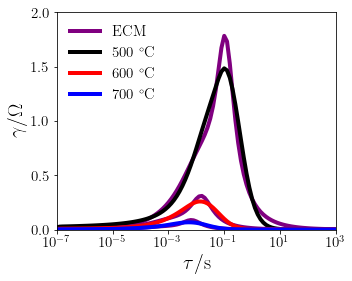

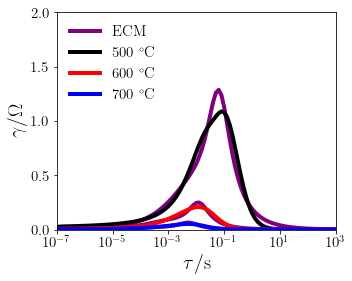

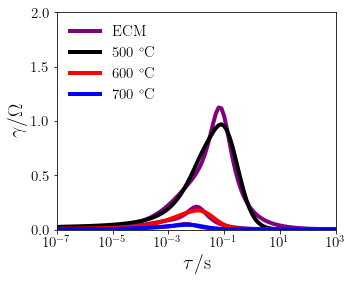

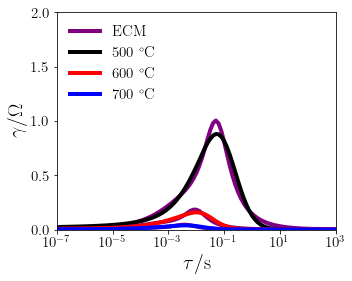

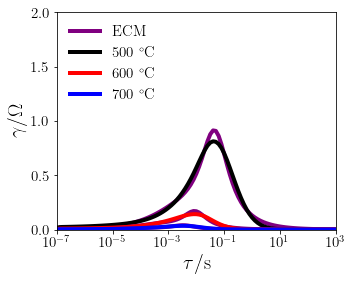

In [26]:
index_temp = 0
for index1, pressure in enumerate(P_range):
    for index2 in range(len(T_range)):
    
        # if (index+1)%2:
        # if (index+1):
        if not (index2+1)%1:
            # stored values
            gamma = gamma_NN_store[-1, :, index1, index2].reshape(N_taus,1)
            
            # correction from x_exact to gamma
            gamma_temp = gamma.detach().cpu().numpy()
            gamma_true = compute_DRT.x_to_gamma(gamma_temp, tau_vec, epsilon, rbf_type)
                                    
            # if index == 0:
                # label_exact = 'exact'
            # label_DRT = "deep-DRT "+str(T_range[index2])+" $^\circ C$"
            # label_DRT_ECM = "ECM "+str(T_range[index2])+" $^\circ C$"
            # label_DRT = "deep-DRT "
            label_DRT = ""+str(T_range[index2])+r" $ \rm ^\circ C$"
            if index2 == 0:
                label_DRT_ECM = "ECM"
            else:
                label_DRT_ECM = ""
            # else:
            #     label_exact = ''
            #     label_DRT = ''      
                
            # plt.semilogx(tau_vec, gamma_exact, linewidth=4, color="blue", label=label_exact)
            # plt.semilogx(tau_vec, gamma, linewidth=4, color="black", label=label_DRT)
            if index2 == 0:
                plt.semilogx(tau_vec, DRT_ECM_list[index_temp], linewidth=4, color="purple", label=label_DRT_ECM)
                plt.semilogx(tau_vec, gamma_true, linewidth=4, color="black", label=label_DRT)
            elif index2 == 2:
                plt.semilogx(tau_vec, DRT_ECM_list[index_temp], linewidth=4, color="purple", label=label_DRT_ECM)
                plt.semilogx(tau_vec, gamma_true, linewidth=4, color="red", label=label_DRT)
            elif index2 == 4:
                plt.semilogx(tau_vec, DRT_ECM_list[index_temp], linewidth=4, color="purple", label=label_DRT_ECM)
                plt.semilogx(tau_vec, gamma_true, linewidth=4, color="blue", label=label_DRT)
            elif index2 == 6:
                plt.semilogx(tau_vec, DRT_ECM_list[index_temp], linewidth=4, color="purple", label=label_DRT_ECM)
                plt.semilogx(tau_vec, gamma_true, linewidth=4, color="green", label=label_DRT)
        index_temp+=1
      
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=15)
    plt.xlim(1E-7, 1E3)
    plt.ylim(0, 2)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.legend(frameon=False, fontsize = 15, loc = 'upper left')
    plt.xlabel(r'$\tau/\rm s$', fontsize=20)
    plt.ylabel(r'$\gamma/\Omega$', fontsize=20)
    fig = plt.gcf()
    fig.set_size_inches(5, 4)
    plt.show()

### 4.2) Impedance and DRT at T = 500°C

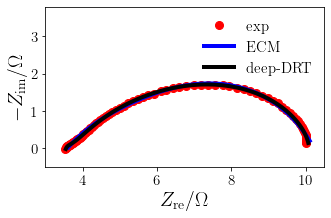

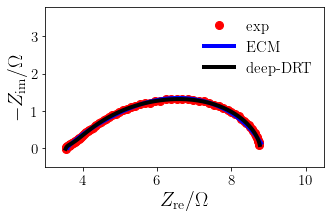

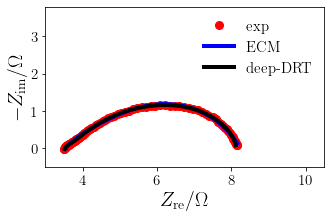

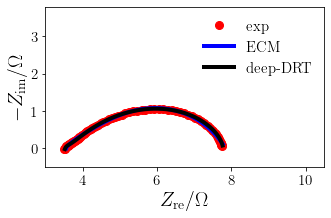

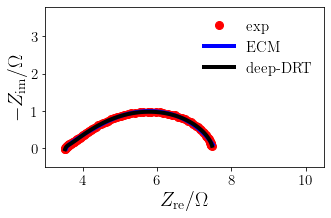

In [45]:
# Nyquist diagram 500 °C

index_temp = 0
for index1, pressure in enumerate(P_range):
    for index2 in range(len(T_range)):

        if index2 == 0:
            # temp = T_range[index_temp]
            # experimental data
            Z_re_exp = Z_re_list[index_temp]
            Z_im_exp = Z_im_list[index_temp]
            
            # A matrices
            A_re = A_re_list[index_temp]
            A_im = A_im_list[index_temp]
            
            # stored values
            x = gamma_NN_store[-1, :, index1, index2].reshape(N_taus,1)
            R_inf = R_inf_NN_store[-1, index_temp]
            freq_times_Lref = freq_times_Lref_list[index_temp]
            L_0 = L_0_NN_store[-1, index_temp]
        
            # model results
            Z_re_model = R_inf + np.matmul(A_re,x)
            Z_im_model = 2.*pi*freq_times_Lref*L_0 + np.matmul(A_im,x)
          
            label_exp = "exp"
            label_DRT = "deep-DRT"
            label_ECM = 'ECM'
               
            plt.plot(Z_re_exp, -Z_im_exp, "o", markersize=8, color="red", label=label_exp)
            plt.plot(Z_re_ECM_list[index_temp], -Z_im_ECM_list[index_temp], linewidth=4, color="blue", label=label_ECM)
            plt.plot(Z_re_model, -Z_im_model, linewidth=4, color="black", label=label_DRT)
            
            plt.rc('text', usetex=True)
            plt.rc('font', family='serif', size=15)
            plt.rc('xtick', labelsize=15)
            plt.rc('ytick', labelsize=15)
            
            plt.axis([3,10.5,-0.5,3.8])
            plt.gca().set_aspect('equal', adjustable='box')
            plt.legend(frameon=False, fontsize = 15, loc='upper right')
            plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
            plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
            plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
            fig = plt.gcf()
            fig.set_size_inches(5, 4)
        index_temp+=1
    plt.show()

### 4.3) impedance and DRT at T = 700°C

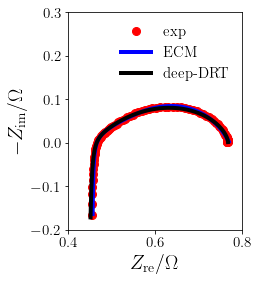

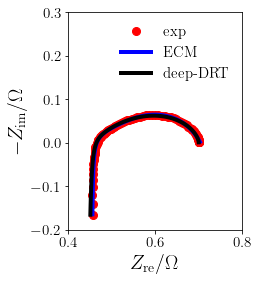

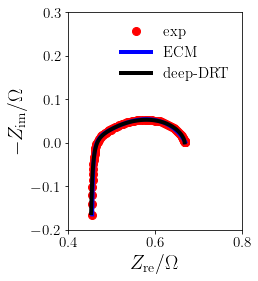

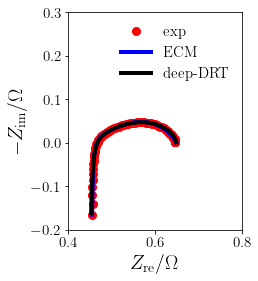

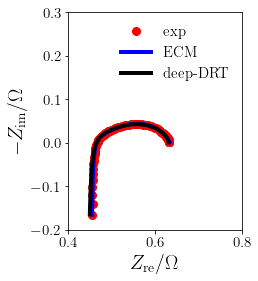

In [47]:
# Nyquist diagram 700 °C

index_temp = 0
for index1, pressure in enumerate(P_range):
    for index2 in range(len(T_range)):
    
        if index2 == 4:
            # temp = T_range[index_temp]
            # experimental data
            Z_re_exp = Z_re_list[index_temp]
            Z_im_exp = Z_im_list[index_temp]
            
            # A matrices
            A_re = A_re_list[index_temp]
            A_im = A_im_list[index_temp]
            
            # stored values
            # x = x_NN_store[iter_opt, :, index].reshape(N_taus,1)
            x = gamma_NN_store[-1, :, index1, index2].reshape(N_taus,1)
            R_inf = R_inf_NN_store[-1, index_temp]
            freq_times_Lref = freq_times_Lref_list[index_temp]
            L_0 = L_0_NN_store[-1, index_temp]
        
            # model results
            Z_re_model = R_inf + np.matmul(A_re,x)
            Z_im_model = 2.*pi*freq_times_Lref*L_0 + np.matmul(A_im,x)
            
            label_exp = "exp"
            label_DRT = "deep-DRT"
            label_ECM = 'ECM'
                
            plt.plot(Z_re_exp, -Z_im_exp, "o", markersize=8, color="red", label=label_exp)
            plt.plot(Z_re_ECM_list[index_temp], -Z_im_ECM_list[index_temp], linewidth=4, color="blue", label=label_ECM)
            plt.plot(Z_re_model, -Z_im_model, linewidth=4, color="black", label=label_DRT)
            
            plt.rc('text', usetex=True)
            plt.rc('font', family='serif', size=15)
            plt.rc('xtick', labelsize=15)
            plt.rc('ytick', labelsize=15)
            
            plt.axis([0.4,0.8,-0.2,0.3])
            plt.gca().set_aspect('equal', adjustable='box')
            plt.legend(frameon=False, fontsize = 15, loc='upper right')
            plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
            plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
            plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
            fig = plt.gcf()
            fig.set_size_inches(5, 4)
        index_temp+=1
    plt.show()

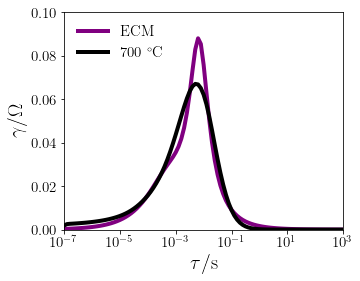

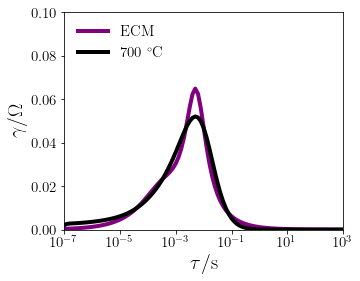

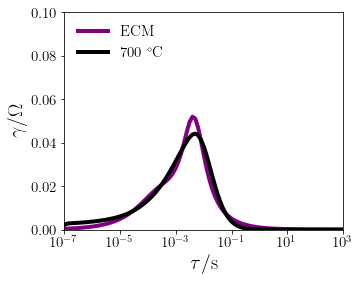

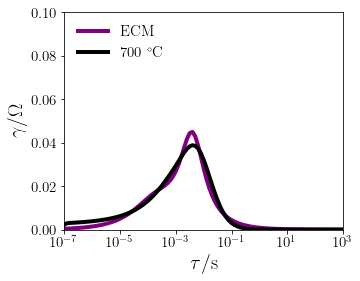

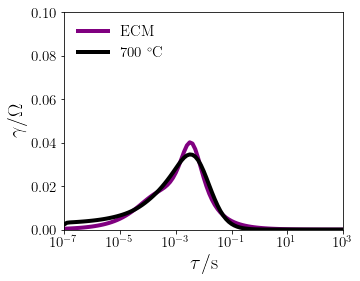

In [48]:
# DRT 700 °C
index_temp = 0
for index1, pressure in enumerate(P_range):
    for index2 in range(len(T_range)):
    
        if index2 == 4:
            # stored values
            gamma = gamma_NN_store[-1, :, index1, index2].reshape(N_taus,1)
            
            # correction from x_exact to gamma
            gamma_temp = gamma.detach().cpu().numpy()
            gamma_true = compute_DRT.x_to_gamma(gamma_temp, tau_vec, epsilon, rbf_type)
                       
            label_DRT = ""+str(T_range[index2])+r" $ \rm ^\circ C$"
            label_DRT_ECM = "ECM"
     
            plt.semilogx(tau_vec, DRT_ECM_list[index_temp], linewidth=4, color="purple", label=label_DRT_ECM)
            plt.semilogx(tau_vec, gamma_true, linewidth=4, color="black", label=label_DRT)
            
        index_temp+=1
      
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=15)
    plt.xlim(1E-7, 1E3)
    plt.ylim(0, 0.1)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.legend(frameon=False, fontsize = 15, loc = 'upper left')
    plt.xlabel(r'$\tau/\rm s$', fontsize=20)
    plt.ylabel(r'$\gamma/\Omega$', fontsize=20)
    fig = plt.gcf()
    fig.set_size_inches(5, 4)
    plt.show()